# My Scratchpad for Zillow Clustering Project

In [1]:
#imports
import pandas as pd
import numpy as np
import acquire
import prepare
import explore
from env import host, user, password

#Visualization Imports
import matplotlib.pyplot as plt
import seaborn as sns

#Sklearn Tools and Modules
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

## Acquire Zillow Data

In [2]:
df = acquire.get_zillow_data(cached=False)
df.head()

,typeconstructiontypeid,storytypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,bathroomcnt,...,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,storydesc,typeconstructiondesc
0,NaN,NaN,2.0,NaN,NaN,NaN,10711855,1087254,NaN,2.0,...,NaN,6.037113e+13,-0.007357,2017-07-07,None,None,None,Central,None,None
1,NaN,NaN,2.0,NaN,NaN,1.0,10711877,1072280,NaN,2.0,...,NaN,6.037113e+13,0.021066,2017-08-29,Central,None,None,Central,None,None
2,NaN,NaN,2.0,NaN,NaN,1.0,10711888,1340933,NaN,2.0,...,NaN,6.037113e+13,0.077174,2017-04-04,Central,None,None,Central,None,None
3,NaN,NaN,2.0,NaN,NaN,NaN,10711910,1878109,NaN,2.0,...,NaN,6.037113e+13,-0.041238,2017-03-17,None,None,None,Central,None,None
4,NaN,NaN,2.0,NaN,NaN,NaN,10711923,2190858,NaN,2.0,...,NaN,6.037113e+13,-0.009496,2017-03-24,None,None,None,Central,None,None


In [3]:
df.shape

(77413, 67)

# Prepare Zillow Data

In [4]:
df = prepare.wrangle_zillow()

In [5]:
df.shape

(69760, 21)

In [6]:
df.columns

Index(['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'latitude', 'longitude',
       'rawcensustractandblock', 'regionidcity', 'regionidzip',
       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'logerror', 'LA',
       'Orange', 'Ventura', 'age', 'taxrate', 'acres', 'cola',
       'hot_month_sale', 'has_heat'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69760 entries, 10711855 to 162960814
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   69760 non-null  float64
 1   bedroomcnt                    69760 non-null  float64
 2   buildingqualitytypeid         69760 non-null  float64
 3   calculatedfinishedsquarefeet  69760 non-null  float64
 4   latitude                      69760 non-null  float64
 5   longitude                     69760 non-null  float64
 6   rawcensustractandblock        69760 non-null  float64
 7   regionidcity                  69760 non-null  float64
 8   regionidzip                   69760 non-null  float64
 9   structuretaxvaluedollarcnt    69760 non-null  float64
 10  landtaxvaluedollarcnt         69760 non-null  float64
 11  logerror                      69760 non-null  float64
 12  LA                            69760 non-null  uin

In [5]:
df.isnull().sum()

bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedfinishedsquarefeet    0
latitude                        0
longitude                       0
rawcensustractandblock          0
regionidcity                    0
regionidzip                     0
structuretaxvaluedollarcnt      0
landtaxvaluedollarcnt           0
logerror                        0
LA                              0
Orange                          0
Ventura                         0
age                             0
taxrate                         0
acres                           0
cola                            0
hot_month_sale                  0
has_heat                        0
dtype: int64

In [6]:
df.head(1)

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,latitude,longitude,rawcensustractandblock,regionidcity,regionidzip,structuretaxvaluedollarcnt,...,logerror,LA,Orange,Ventura,age,taxrate,acres,cola,hot_month_sale,has_heat
parcelid,,,,,,,,,,,,,,,,,,,,,
10711855,2.0,3.0,8.0,2107.0,34.222559,-118.617387,6.037113e+07,12447.0,96339.0,249655.0,...,-0.007357,1,0,0,45.0,1.227188,0.210239,1,1,1


In [7]:
def get_counties():
    '''
    This function will create dummy variables out of the original fips column. 
    And return a dataframe with all of the original columns except regionidcounty.
    We will keep fips column for data validation after making changes. 
    New columns added will be 'LA', 'Orange', and 'Ventura' which are boolean 
    The fips ids are renamed to be the name of the county each represents. 
    '''
    # create dummy vars of fips id
    county_df = pd.get_dummies(df.fips)
    # rename columns by actual county name
    county_df.columns = ['LA', 'Orange', 'Ventura']
    # concatenate the dataframe with the 3 county columns to the original dataframe
    df_dummies = pd.concat([df, county_df], axis = 1)
    # drop regionidcounty and fips columns
    df_dummies = df_dummies.drop(columns = ['regionidcounty'])
    return df_dummies

In [8]:
df = get_counties()
df.head()

AttributeError: 'DataFrame' object has no attribute 'fips'

In [ ]:
df.columns

In [9]:
df.sample(10).T

parcelid,13070099,14711467,14714760,14409296,12894976,13927326,14481690,12171350,10932798,11163194
bathroomcnt,6.000000e+00,1.000000e+00,2.500000e+00,4.500000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.000000e+00,3.000000e+00,2.000000e+00
bedroomcnt,5.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
buildingqualitytypeid,9.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,4.000000e+00,7.000000e+00,6.000000e+00
calculatedfinishedsquarefeet,8.251000e+03,8.220000e+02,1.148000e+03,5.475000e+03,1.140000e+03,1.651000e+03,3.726000e+03,1.109000e+03,1.645000e+03,1.226000e+03
latitude,3.402934e+01,3.377900e+01,3.356179e+01,3.351476e+01,3.410432e+01,3.378831e+01,3.360976e+01,3.417309e+01,3.415190e+01,3.438136e+01
longitude,-1.178639e+02,-1.179970e+02,-1.177324e+02,-1.176419e+02,-1.177407e+02,-1.180848e+02,-1.175755e+02,-1.181289e+02,-1.183550e+02,-1.185366e+02
rawcensustractandblock,6.037403e+07,6.059088e+07,6.059063e+07,6.059032e+07,6.037402e+07,6.059110e+07,6.059032e+07,6.037461e+07,6.037143e+07,6.037920e+07
regionidcity,3.463600e+04,4.296700e+04,3.708600e+04,3.384000e+04,2.000800e+04,4.631400e+04,1.759700e+04,4.701900e+04,1.244700e+04,5.431100e+04
regionidzip,9.652200e+04,9.620300e+04,9.697400e+04,9.698500e+04,9.650700e+04,9.621800e+04,9.698900e+04,9.629200e+04,9.644700e+04,9.635200e+04
structuretaxvaluedollarcnt,1.174946e+06,5.993700e+04,1.531690e+05,7.448510e+05,7.317700e+04,9.180900e+04,4.537640e+05,1.304760e+05,2.263670e+05,1.535690e+05


In [10]:
df.roomcnt.describe()

AttributeError: 'DataFrame' object has no attribute 'roomcnt'

#### Decisions / To-Do List:
- Add get_counties function to prepare module and update wrangle_zillow
- 

#### Questions:
- Why are there 0s in roomcnt? - Is this column valuable?
- Do I need to keep County and FIPS after encoding? 


In [11]:
df.columns.to_list()

['bathroomcnt',
 'bedroomcnt',
 'buildingqualitytypeid',
 'calculatedfinishedsquarefeet',
 'latitude',
 'longitude',
 'rawcensustractandblock',
 'regionidcity',
 'regionidzip',
 'structuretaxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'logerror',
 'LA',
 'Orange',
 'Ventura',
 'age',
 'taxrate',
 'acres',
 'cola',
 'hot_month_sale',
 'has_heat']

In [12]:
def create_features(df):
    df['age'] = 2017 - df.yearbuilt
    df['age_bin'] = pd.cut(df.age, 
                           bins = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140],
                           labels = [0, .066, .133, .20, .266, .333, .40, .466, .533, 
                                     .60, .666, .733, .8, .866, .933])

    # create taxrate variable
    df['taxrate'] = df.taxamount/df.taxvaluedollarcnt*100

    # create acres variable
    df['acres'] = df.lotsizesquarefeet/43560

    # bin acres
    df['acres_bin'] = pd.cut(df.acres, bins = [0, .10, .15, .25, .5, 1, 5, 10, 20, 50, 200], 
                       labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9])

    # square feet bin
    df['sqft_bin'] = pd.cut(df.calculatedfinishedsquarefeet, 
                            bins = [0, 800, 1000, 1250, 1500, 2000, 2500, 3000, 4000, 7000, 12000],
                            labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                       )

    # dollar per square foot-structure
    df['structure_dollar_per_sqft'] = df.structuretaxvaluedollarcnt/df.calculatedfinishedsquarefeet


    df['structure_dollar_sqft_bin'] = pd.cut(df.structure_dollar_per_sqft, 
                                             bins = [0, 25, 50, 75, 100, 150, 200, 300, 500, 1000, 1500],
                                             labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                                            )


    # dollar per square foot-land
    df['land_dollar_per_sqft'] = df.landtaxvaluedollarcnt/df.lotsizesquarefeet

    df['lot_dollar_sqft_bin'] = pd.cut(df.land_dollar_per_sqft, bins = [0, 1, 5, 20, 50, 100, 250, 500, 1000, 1500, 2000],
                                       labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                                      )


    # update datatypes of binned values to be float
    df = df.astype({'sqft_bin': 'float64', 'acres_bin': 'float64', 'age_bin': 'float64',
                    'structure_dollar_sqft_bin': 'float64', 'lot_dollar_sqft_bin': 'float64'})


    # ratio of bathrooms to bedrooms
    df['bath_bed_ratio'] = df.bathroomcnt/df.bedroomcnt

    # 12447 is the ID for city of LA. 
    # I confirmed through sampling and plotting, as well as looking up a few addresses.
    df['cola'] = df['regionidcity'].apply(lambda x: 1 if x == 12447.0 else 0)

    return df

In [13]:
df = create_features(df)

AttributeError: 'DataFrame' object has no attribute 'yearbuilt'

In [14]:
df.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,latitude,longitude,rawcensustractandblock,regionidcity,regionidzip,structuretaxvaluedollarcnt,...,logerror,LA,Orange,Ventura,age,taxrate,acres,cola,hot_month_sale,has_heat
parcelid,,,,,,,,,,,,,,,,,,,,,
10711855,2.0,3.0,8.0,2107.0,34.222559,-118.617387,6.037113e+07,12447.0,96339.0,249655.0,...,-0.007357,1,0,0,45.0,1.227188,0.210239,1,1,1
10711877,2.0,4.0,8.0,1882.0,34.220261,-118.616409,6.037113e+07,12447.0,96339.0,253000.0,...,0.021066,1,0,0,45.0,1.230895,0.207415,1,1,1
10711888,2.0,4.0,8.0,1882.0,34.222491,-118.616854,6.037113e+07,12447.0,96339.0,257591.0,...,0.077174,1,0,0,45.0,1.229132,0.224977,1,0,1
10711910,2.0,3.0,8.0,1477.0,34.221864,-118.615739,6.037113e+07,12447.0,96339.0,57968.0,...,-0.041238,1,0,0,57.0,1.430790,0.259068,1,0,1
10711923,2.0,4.0,8.0,1918.0,34.220619,-118.615253,6.037113e+07,12447.0,96339.0,167869.0,...,-0.009496,1,0,0,57.0,1.261220,0.258012,1,0,1


In [15]:
df.drop(columns={'fips','roomcnt','unitcnt', 'assessmentyear','logerror_class','county'}, inplace=True)

KeyError: "['county' 'logerror_class' 'unitcnt' 'assessmentyear' 'roomcnt' 'fips'] not found in axis"

# Explore Zillow Data

### Check for outliers in Features

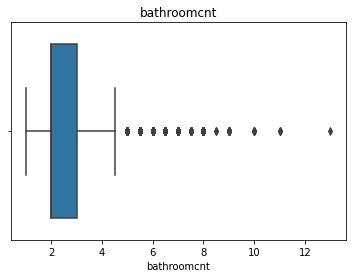

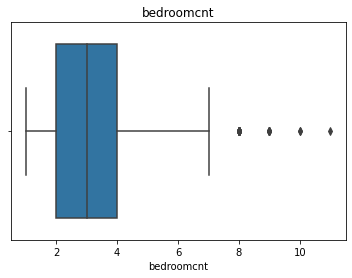

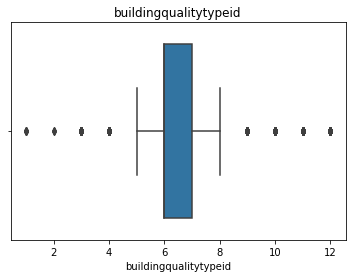

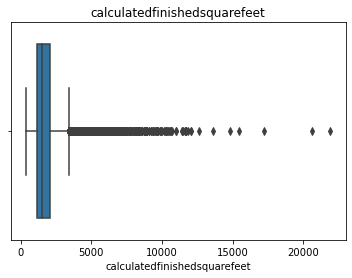

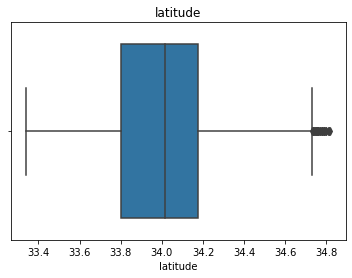

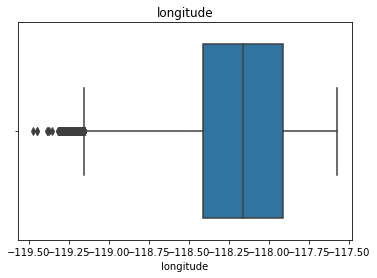

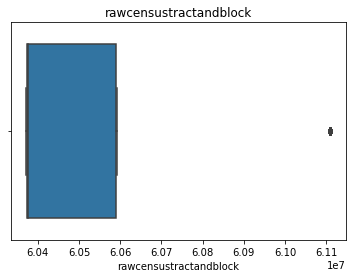

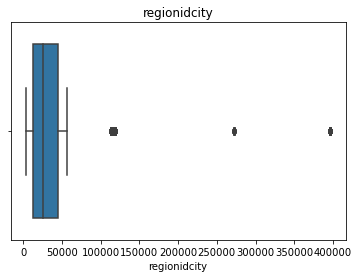

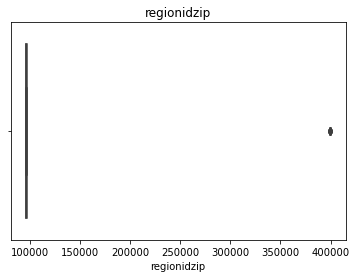

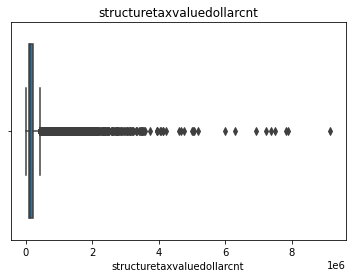

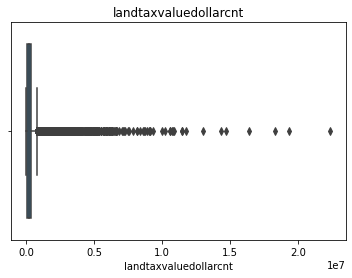

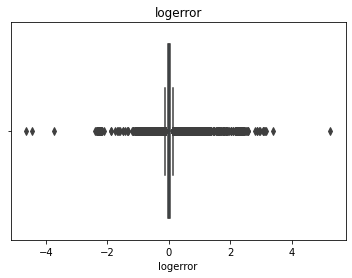

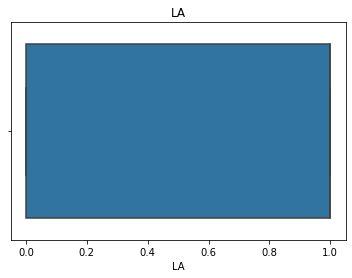

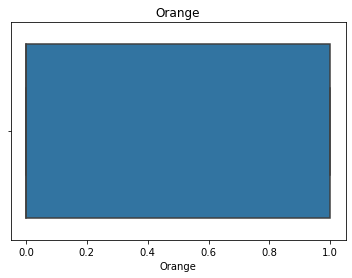

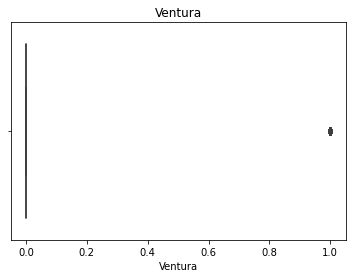

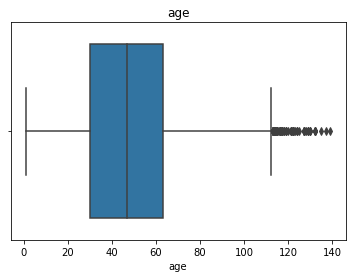

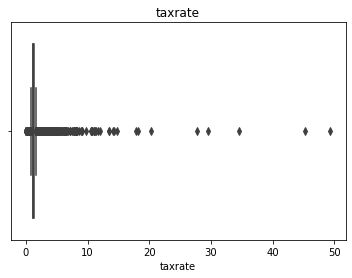

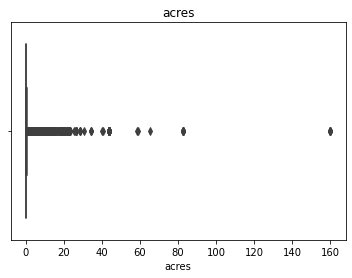

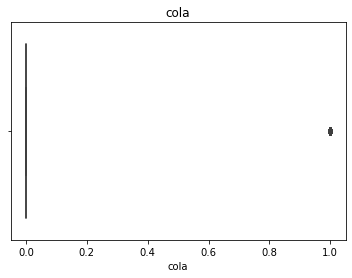

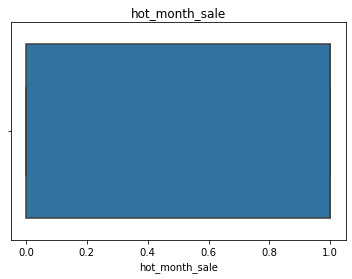

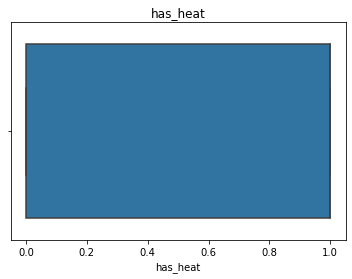

In [16]:
#Explore Dists of Features:
for col in df.columns:
    sns.boxplot(df[col])
    plt.title(col)
    plt.show()

### Takeaways:
- Should I deal with outliers in Bathroom count? This was a strong feature/ reliable in regression project without removing outliers of bathroom count directly.
- Outliers in bedroom count as well...Make a feature bedrooms/bathrooms?
- Building Quality type id looks centered / normally distributed
- Outliers in finished square feet 
- Outlier in FIPS? Is that Ventura County? 
- Lat and Long look okay...no action for now
- Lotsize square feet has outliers on upperbound
- Rawcensustractandblock...still need to determine what this is
- Regionid City...Most properties in LA?
- Regionzip...still want to deal with this...suspect errors in data
- roomcnt...most are 0? It is total number of rooms in principal of residence...Should just drop
- Unit count is as expected...drop since all values are equal
- Year built has some outliers...should create new feature for age of home? 
- Structuretaxvaluedollar cnt has outliers in upperbound 
- Assessment year is the same for all properties. Drop column
- Landtax value dollar cnt has has upperbound outliers...Do these outliers correspond with sturcture tax value dollar count?
- Logerror has outliers..How do I want to handle this? Leave as is for the first iteration. 

In [24]:
def outlier_label(x, lower, upper):
    if (lower >= x) or (x >= upper):
        return 'Yes'
    else:
        
        return 'No'

In [37]:
def outlier_report(df):
    df = prepare.wrangle_zillow()
    
    columns_to_check = ['bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet',
       'acres', 'rawcensustractandblock','age',
       'structuretaxvaluedollarcnt', 'taxrate',
       'landtaxvaluedollarcnt', 'logerror']
    
    for col in columns_to_check:
        quartile_01, quartile_03 = np.percentile(df[col], [25, 75])
        iqr = quartile_03 - quartile_01
    
        lower_bound = quartile_01 -(3 * iqr)
        upper_bound = quartile_03 +(3 * iqr)
    
        df['outlier'] = df[col].apply(lambda x: outlier_label(x, lower_bound, upper_bound))
    

        print(f"The lower and upper bound of the range for '{col}' respectively is: {lower_bound} and {upper_bound}")
    

In [38]:
outlier_report(df)

The lower and upper bound of the range for 'bathroomcnt' respectively is: -1.0 and 6.0
The lower and upper bound of the range for 'bedroomcnt' respectively is: -4.0 and 10.0
The lower and upper bound of the range for 'calculatedfinishedsquarefeet' respectively is: -1498.0 and 4718.0
The lower and upper bound of the range for 'acres' respectively is: -0.18906680440771345 and 0.5734848484848485
The lower and upper bound of the range for 'rawcensustractandblock' respectively is: 59720887.482094 and 61242751.692933
The lower and upper bound of the range for 'age' respectively is: -69.0 and 162.0
The lower and upper bound of the range for 'structuretaxvaluedollarcnt' respectively is: -310183.5 and 607458.75
The lower and upper bound of the range for 'taxrate' respectively is: 0.638194924850068 and 1.8603032169299083
The lower and upper bound of the range for 'landtaxvaluedollarcnt' respectively is: -773788.0 and 1224750.5
The lower and upper bound of the range for 'logerror' respectively is

In [ ]:
columns_to_check = ['bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet',
       'lotsizesquarefeet', 'rawcensustractandblock','yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'logerror']

In [ ]:
for col in columns_to_check:
    quartile_01, quartile_03 = np.percentile(df[col], [25, 75])
    iqr = quartile_03 - quartile_01
    
    lower_bound = quartile_01 -(3 * iqr)
    upper_bound = quartile_03 +(3 * iqr)
    
    df['outlier'] = df[col].apply(lambda x: outlier_label(x, lower_bound, upper_bound))
    

    print(f"The lower and upper bound of the range for '{col}' respectively is: {lower_bound} and {upper_bound}")

In [ ]:
outliers = df['outlier'] == 'Yes' # filter for outliers
df[outliers][['bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet',
       'lotsizesquarefeet', 'rawcensustractandblock','yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'logerror']].groupby('parcelid').head()

In [ ]:
#How many total outliers are there in the dataframe as defined by the outlier function above?
len(df[df.outlier == 'Yes'])

In [ ]:
df.shape

In [ ]:
print(f'The % of observations lost by removing all outliers is: {69920/3752}%')

**If I just remove all outliers in the features listed above in columns_to_check, I would lose 18.63 % of the data.**

#### Explore the distributions

In [ ]:
for col in df.columns:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

**Takeaways:**
- Need to deal with outliers in 
    - calculatedfinishedsquarefeet
    - lotsizesquarefeet
    - taxdollarvaluecnt
- roomcnt has errors - need to drop


In [ ]:
def remove_outliers():
    '''
    remove outliers in bed, bath, square feet
    '''

    return df[((df.bathroomcnt <= 7) & (df.bedroomcnt <= 11) & 
               (df.bathroomcnt > 0) & 
               (df.bedroomcnt > 0) & 
               (df.calculatedfinishedsquarefeet < 4717) 
               )]

In [ ]:
df = remove_outliers()

# Now that the most extreme outliers have been removed, let's look at the summary statistics of each numeric field. 
df.describe().T

In [ ]:
df.shape

In [ ]:
df.columns

### Now I am going to break up the dataframe into three separate dfs by county

In [ ]:
#Create LA County Dataframe
df_la = df[df.LA == 1].drop(columns = ['bedroomcnt', 'taxamount', 'taxvaluedollarcnt', 
                                       'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'yearbuilt', 
                                       'lotsizesquarefeet', 'regionidcity', 'regionidzip', 
                                       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 
                                       'LA', 'Ventura', 'Orange']) 
df_la.shape

In [ ]:
#Create Ventura County Dataframe
df_vent = df[df.Ventura == 1].drop(columns = ['bedroomcnt', 'taxamount', 'taxvaluedollarcnt', 
                                       'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'yearbuilt', 
                                       'lotsizesquarefeet', 'regionidcity', 'regionidzip', 
                                       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 
                                       'LA', 'Ventura', 'Orange']) 
df_vent.shape

In [ ]:
#Create Orange County Dataframe
df_orange = df[df.Orange == 1].drop(columns = ['bedroomcnt', 'taxamount', 'taxvaluedollarcnt', 
                                       'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'yearbuilt', 
                                       'lotsizesquarefeet', 'regionidcity', 'regionidzip', 
                                       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 
                                       'LA', 'Ventura', 'Orange']) 
df_orange.shape

#### Starting with Analysis for LA County Props

In [ ]:
def split(df, target_var):
    '''
    This function takes in the dataframe and target variable name as arguments and then
    splits the dataframe into train (56%), validate (24%), & test (20%)
    It will return a list containing the following dataframes: train (for exploration), 
    X_train, X_validate, X_test, y_train, y_validate, y_test
    '''
    # split df into train_validate (80%) and test (20%)
    train_validate, test = train_test_split(df, test_size=.20, random_state=13)
    # split train_validate into train(70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=13)

    # create X_train by dropping the target variable 
    X_train = train.drop(columns=[target_var])
    # create y_train by keeping only the target variable.
    y_train = train[[target_var]]

    # create X_validate by dropping the target variable 
    X_validate = validate.drop(columns=[target_var])
    # create y_validate by keeping only the target variable.
    y_validate = validate[[target_var]]

    # create X_test by dropping the target variable 
    X_test = test.drop(columns=[target_var])
    # create y_test by keeping only the target variable.
    y_test = test[[target_var]]

    partitions = [train, X_train, X_validate, X_test, y_train, y_validate, y_test]
    return partitions

In [ ]:
partitions = split(df_la, target_var='logerror')

In [ ]:
train = partitions[0]
train['logerror_bins'] = pd.cut(train.logerror, [-5, -.2, -.05, .05, .2, 4])
partitions[0] = train

In [ ]:
train.logerror_bins.value_counts()

#### Bivariate Analysis on train for LA County

In [ ]:
train.columns

In [ ]:
train.info()

In [ ]:
#Separate logerror into quantiles
train['logerror_class'] = pd.qcut(train.logerror, q=4, labels=['q1', 'q2', 'q3', 'q4'])

In [ ]:
categorical_target = ['logerror_class']
continuous_target = ['logerror']
binary_vars = ['cola']
quant_vars = ['bathroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet',
       'latitude', 'longitude', 'rawcensustractandblock',
       'transactiondate', 'heatingorsystemdesc', 'age', 'age_bin', 'taxrate',
       'acres', 'acres_bin', 'sqft_bin', 'structure_dollar_sqft_bin',
       'lot_dollar_sqft_bin', 'bath_bed_ratio', 'cola', 'logerror_bins']

In [ ]:
train.head()

In [ ]:
explore.explore_bivariate(train, categorical_target, continuous_target, binary_vars, quant_vars)

In [ ]:
#Multivariate Analysis
#sns.pairplot(data = train, hue = 'logerror_bins', 
#             x_vars = ['logerror', 'structuretaxvaluedollarcnt','landtaxvaluedollarcnt', 'taxvaluedollarcnt', 'taxamount'],
#             y_vars = ['logerror', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt'])

#### Scale Continuous Features

In [ ]:
train.columns

In [ ]:
#Add this column to the above drop columns list
train.drop(columns={'transactiondate'},inplace=True)

In [ ]:
train.drop(columns={'logerror_class'}, inplace=True)

In [ ]:
# the variables that still need scaling
scaled_vars = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'latitude', 'longitude',
       'lotsizesquarefeet', 'rawcensustractandblock', 'regionidcity',
       'regionidzip', 'yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']

# create new column names for the scaled variables by adding 'scaled_' to the beginning of each variable name 
scaled_column_names = ['scaled_' + i for i in scaled_vars]

# select the X partitions: [X_train, X_validate, X_test]
X = partitions[1:4]

# fit the minmaxscaler to X_train
X_train = X[0]
scaler = MinMaxScaler(copy=True).fit(X_train[scaled_vars])


def scale_and_concat(df):
    scaled_array = scaler.transform(df[scaled_vars])
    scaled_df = pd.DataFrame(scaled_array, columns=scaled_column_names, index=df.index.values)
    return pd.concat((df, scaled_df), axis=1)

for i in range(len(X)):
    X[i] = scale_and_concat(X[i])

In [ ]:
# recall: X[0] is X_train, X[1] is X_validate and X[2] is X_test
X[0].describe()

In [ ]:
# list of variables I will cluster on. 
cluster_vars = ['scaled_latitude', 'scaled_longitude', 'scaled_yearbuilt']
cluster_name = 'area_cluster'
k_range = range(2,20)

In [ ]:
def find_k(X_train, cluster_vars, k_range):
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)

        # X[0] is our X_train dataframe..the first dataframe in the list of dataframes stored in X. 
        kmeans.fit(X_train[cluster_vars])

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_) 

    # compute the difference from one k to the next
    delta = [round(sse[i] - sse[i+1],0) for i in range(len(sse)-1)]

    # compute the percent difference from one k to the next
    pct_delta = [round(((sse[i] - sse[i+1])/sse[i])*100, 1) for i in range(len(sse)-1)]

    # create a dataframe with all of our metrics to compare them across values of k: SSE, delta, pct_delta
    k_comparisons_df = pd.DataFrame(dict(k=k_range[0:-1], 
                             sse=sse[0:-1], 
                             delta=delta, 
                             pct_delta=pct_delta))

    # plot k with inertia
    plt.plot(k_comparisons_df.k, k_comparisons_df.sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('The Elbow Method to find the optimal k\nFor which k values do we see large decreases in SSE?')
    plt.show()

    # plot k with pct_delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.pct_delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Percent Change')
    plt.title('For which k values are we seeing increased changes (%) in SSE?')
    plt.show()

    # plot k with delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Absolute Change in SSE')
    plt.title('For which k values are we seeing increased changes (absolute) in SSE?')
    plt.show()

    return k_comparisons_df

In [ ]:
find_k(X[0], cluster_vars, k_range)